In [1]:
from collections import namedtuple
import csv
import psycopg2
import sys
from mytables import Compound

from razi.rdkit_postgresql.types import Mol, Bfp
from razi.rdkit_postgresql.functions import atompairbv_fp, torsionbv_fp, morganbv_fp, mol_amw

from rdkit import Chem, rdBase
from rdkit.Chem import Draw

from sqlalchemy import create_engine, desc, Column, Index, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker


print(sys.version_info)
print(f'RDKit version: {rdBase.rdkitVersion}')

sys.version_info(major=3, minor=6, micro=0, releaselevel='final', serial=0)
RDKit version: 2017.03.1


### 1. テーブルの定義と構築

複数のNotebookで利用ができるように化学構造情報を保存するテーブルは[mytables.py](http://0.0.0.0:8888/edit/tutorial/mytables.py)に保存し  
`from mytables import Compound`で読み込んでいる。

例えば以下のセルを実行することテーブル`compounds`の定義及び構築をすることができる。

In [2]:
!python mytables.py

以下で具体的にどのようなテーブルが定義、構築されたか説明していく。  
[mytables.py](http://0.0.0.0:8888/edit/tutorial/mytables.py)のコードも随時確認しながら進めてもらえるとよい。

[SQLAlchemy](http://docs.sqlalchemy.org/en/latest/orm/tutorial.html)をすでに利用している方にわかりやすく説明するとSQLAlchemyでテーブルの定義をする方法と同じように`Razi`でも定義することができる。  
その際カラムのデータ型として化学構造データを保存する`Mol`が追加されている。

最初に`create_engine`関数を用いてPostgreSQLに接続する。  
引数として`postgresql://ユーザー名:パスワード@接続先:ポート/データベース名`を与える。  
今回は`ユーザー名=postgres`, `パスワード=なし`, `接続先=db`, `ポート=5432`, `データベース名=postgres` であるので以下のようになる。

```
engine = create_engine('postgresql://postgres@db:5432/postgres')
Base = declarative_base(bind=engine)
```

PostgresSQLに接続したengineを引数とした`Base`クラスを作成する。  
この`Base`クラスを継承したクラスを新たに作ることで`SQLAlchemy`や`Razi`ではデータベース内に存在するテーブルを定義していることになる。

実際に`Compound`という名前のテーブルを定義していってみる。

```
class Compound(Base):
    __tablename__ = 'compounds'
    
    id = Column(Integer, primary_key=True)
    name = Column(String)
    structure = Column(Mol)
    atompair = Column(Bfp)
    torsion = Column(Bfp)
    morgan = Column(Bfp)
    
    __table_args__ = (
        Index('compounds_structure', 'structure',
                    postgresql_using='gist'),
        )
    
    def __init__(self, name, structure):
        self.name = name
        if isinstance(structure, Chem.Mol):
            self.structure = Chem.MolToSmiles(structure)
        elif isinstance(structure, str):
            self.structure = structure
        self.atompair = atompairbv_fp(self.structure)
        self.torsion = torsionbv_fp(self.structure)
        self.morgan = morganbv_fp(self.structure, 2)
        
    def __repr__(self):
        if isinstance(self.structure, Chem.Mol):
            return '(%s) < %s >' % (self.name, Chem.MolToSmiles(self.structure))
        return '(%s) < %s >' % (self.name, self.structure)
```

`Compound`クラスの中を詳しく説明していこう。

#### 1.1 テーブルの定義

#### 1.1.1 テーブルの名前

```
    __tablename__ = 'compounds'
```

初めに`__tablename__`attributeにテーブルの名前`compounds`を定義している。

#### 1.1.2 テーブルのカラム

続けて以下のようにテーブル`compounds`の各カラムを定義する。

```
    id = Column(Integer, primary_key=True)
    name = Column(String)
    structure = Column(Mol)
    atompair = Column(Bfp)
    torsion = Column(Bfp)
    morgan = Column(Bfp)
```


テーブル`compounds`は`id`, `name`, `structure`という名前のカラムを持つように定義されている。  
(`atompair`, `torsion`, `morgan`に関しては[Razi-tutorial2-japanese.ipynb]で説明するのでこのチュートリアルでは説明しない)  
SQLAlchemyやraziではattributeに初期値として`Column`クラスをあたえることで`compounds`テーブルのカラムとして定義することができる。  
さらに`Column`クラスのコンストラクタの引数に`Integer`, `String`, `Mol`を与えることで  
それぞれ整数値、文字列、化学構造を保存するカラムであると定義している。  
加えて`id`には引数として`primary_key=True`を与えることでPrimary key(主キー)であると定義している。

ここまでの定義でテーブル`compounds`は以下のようなテーブルだと想像してもらえるとわかりやすいと思う。

|id| name | structure | 
|:---|----|---:|
|1|Benzen|c1ccccc1|
|2|Aspirin|CC(=O)Oc1ccccc1C(=O)O|
|3|Oseltamivir|CCC(CC)OC1C=C(CC(C1NC(=O)C)N)C(=O)OCC|

#### 1.1.3 インデックス 

続けて`structure`カラムにインデックスを作成する。インデックスを作成することで登録しているデータ数が増えるても高速な検索を可能になる。

```
    __table_args__ = (
        Index('compounds_structure', 'structure',
                    postgresql_using='gist'),
        )
```

`Index`クラスの引数は前から順番にインデックスの名前(データベース内で重複してなければどんな名前でもよい), インデックスを作成するカラム,  
用いるインデックスの種類である。[RDKit database cartridge](http://www.rdkit.org/docs/Cartridge.html)では化学構造を保存する`mol`に対応しているインデックスは`gist`のみである。

#### 1.1.4 コンストラクタ

コンストラクタの中はSQLAlchemy, raziでは特に決まりがないが、最終的に各カラムに適切な値を与える必要がある。  
今回は利便性を考えて引数`structure`は`str`でもRDKitの`rdkit.Chem.rdchem.Mol`オブジェクトでもよいようにしてみた。

```
    def __init__(self, name, structure):
        self.name = name
        if isinstance(structure, Chem.Mol):
            self.structure = Chem.MolToSmiles(structure)
        elif isinstance(structure, str):
            self.structure = structure
        self.atompair = atompairbv_fp(self.structure)
        self.torsion = torsionbv_fp(self.structure)
        self.morgan = morganbv_fp(self.structure, 2)
```

#### 1.1.5 __repr__メソッド

最後に[\__repr__](https://docs.python.jp/3/reference/datamodel.html#object.__repr__)メソッドを定義する。こちらは`print`などでどう表示されるか定義するだけで今回話をしている化合物データベース特有の話ではない。  
あくまで人間の目で見た時にどういうデータかわかりやすくしているだけであるので省略してもかまわない。  
こちらも`structure` attributeに`str`オブジェクトあるいは`rdkit.Chem.rdchem.Mol`オブジェクトのいずれかが入る可能性があるのでどちらでもよいようにしてみた。

```
    def __repr__(self):
        if isinstance(self.structure, Chem.Mol):
            return '(%s) < %s >' % (self.name, Chem.MolToSmiles(self.structure))
        return '(%s) < %s >' % (self.name, self.structure)
```

以上でテーブルの定義は終わりである。

#### 1.2 テーブルの構築

次に、定義したテーブルを構築するには`Base.metadata.create_all`メソッドを実行する。

```
if __name__ == '__main__':
    Base.metadata.create_all()
```

SQL言語がわかる方にわかりやすいように説明するとPostgreSQL内に以下のように定義されたテーブルが作成されている。

```
postgres=# \d compounds;
                                Table "public.compounds"
  Column   |       Type        |                       Modifiers                        
-----------+-------------------+--------------------------------------------------------
 id        | integer           | not null default nextval('compounds_id_seq'::regclass)
 name      | character varying | 
 structure | mol               | 
 atompair  | bfp               | 
 torsion   | bfp               | 
 morgan    | bfp               | 
Indexes:
    "compounds_pkey" PRIMARY KEY, btree (id)
    "compounds_structure" gist (structure)
```

以上でテーブル`compounds`の定義、構築に関する説明は終わりである。

### 2. データベースに接続する

それではデータベースに接続し、[1. テーブルの定義と構築](#1.-%E3%83%86%E3%83%BC%E3%83%96%E3%83%AB%E3%81%AE%E5%AE%9A%E7%BE%A9%E3%81%A8%E6%A7%8B%E7%AF%89)で作成したテーブル`compounds`にアクセスしたりデータを登録したりしてみよう。  
`create_engine`関数を用いてPostgreSQLに接続する。続けてテーブルを定義するクラスが継承する`Base`クラスを呼び出す。  
最後に`sesionmaker`から作成した`Session`クラスのオブジェクトを作成し、データベースにアクセスしたりデータを登録したりすることができる。  

これらの作業はデータベースに接続するたびに最初に必ず行う必要がある。

In [34]:
engine = create_engine('postgresql://postgres@db:5432/postgres')
Base = declarative_base(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### 3. データの登録

#### 3.1 登録データのダウンロード

例えば以下のように`wget`などでCHEMBLから`chembl_23_chemreps.txt.gz`をダウンロードおよび解凍し、  
このNotebookがある`work/tutorial`ディレクトリに入れてください。

```
wget ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_23/chembl_23_chemreps.txt.gz
gunzip chembl_23_chemreps.txt.gz
```

#### 3.2 データを抽出する関数の作成

CHEMBLのデータである`chembl_23_chemreps.txt`は以下のような形式で保存されている。

In [4]:
!head -n3 chembl_23_chemreps.txt

chembl_id	canonical_smiles	standard_inchi	standard_inchi_key
CHEMBL153534	Cc1cc(cn1C)c2csc(N=C(N)N)n2	InChI=1S/C10H13N5S/c1-6-3-7(4-15(6)2)8-5-16-10(13-8)14-9(11)12/h3-5H,1-2H3,(H4,11,12,13,14)	MFRNFCWYPYSFQQ-UHFFFAOYSA-N
CHEMBL440060	CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](N)CCSC)[C@@H](C)O)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CC(=O)N)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N2CCC[C@H]2C(=O)N3CCC[C@H]3C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N	InChI=1S/C123H212N44O34S/c1-19-63(12)96(164-115(196)81(47-62(10)11)163-119(200)97(68(17)169)165-103(184)70(124)36-42-202-18)118(199)143-52-92(175)147-65(14)100(181)149-67(16)102(183)157-82(48-69-50-136-57-145-69)114(195)162-83(49-90(128)173)106(187)141-51-91(174)146-64(13

このファイルからvalidなsmilesとそれに対応する`CHEMBL ID`そして新たな`ID`を割り当てる関数`read_chembldb`を以下のように作成した。

In [5]:
Record = namedtuple('Record', 'chembl_id, smiles, inchi, inchi_key')


def read_chembldb(filepath, limit):
    with open(filepath, 'rt') as inputfile:
            reader = csv.reader(inputfile, delimiter='\t', skipinitialspace=True)
            #headerを飛ばす
            next(reader)

            for count, record in enumerate(map(Record._make, reader), start=1):
                smiles = record.smiles

                #特定の三重結合をRDKitで読めるように変換する。
                smiles = smiles.replace('=N#N','=[N+]=[N-]')
                smiles = smiles.replace('N#N=','[N-]=[N+]=')            

                #invalidなsmilesは読み込まない
                if not Chem.MolFromSmiles(smiles):
                    continue

                yield count, record.chembl_id, smiles
                if count == limit:
                    break

期待する通りに関数が動いているか確かめる。関数`read_chembldb`は引数`limit`の数の行だけデータを取り出す作業を行う。  
今回は`limit=3`で行ってみる。

In [6]:
for count, chembl_id, smiles in read_chembldb('chembl_23_chemreps.txt', 3):
    print(count, chembl_id, smiles)

1 CHEMBL153534 Cc1cc(cn1C)c2csc(N=C(N)N)n2
2 CHEMBL440060 CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@@H](N)CCSC)[C@@H](C)O)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](Cc1c[nH]cn1)C(=O)N[C@@H](CC(=O)N)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](CCCN=C(N)N)C(=O)NCC(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CC(C)C)C(=O)NCC(=O)N2CCC[C@H]2C(=O)N3CCC[C@H]3C(=O)NCC(=O)N[C@@H](CO)C(=O)N[C@@H](CCCN=C(N)N)C(=O)N
3 CHEMBL440245 CCCC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](CO)NC(=O)[C@H](Cc1c[nH]cn1)NC(=O)[C@H](C)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@@H]2CCCCNC(=O)CC[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](Cc3c[nH]cn3)NC(=O)[C@H](N)Cc4ccccc4)C(

期待する通りに関数が動いているようだ。

#### 3.3 データの登録

データを実際に登録してみる。定義したテーブル`Compound`クラスから一般的なオブジェクト指向型プログラミングにおけるオブジェクトを作成し、  
sessionオブジェクトの`add`メソッドを用いて登録すれば良い。`read_chembldb`の引数`limit=25000`で行ってみる。  
マシンパワーによっては登録に時間がかかるかもしれない。

In [7]:
for count, chembl_id, smiles in read_chembldb('chembl_23_chemreps.txt', 25000):
    compound = Compound(chembl_id, smiles)
    session.add(compound)
session.commit()
session.close()

私のパソコンだと1分ほどで登録が終了した。また別の登録方法としてRDkitのMolオブジェクトを引数に与えてもよい。

In [8]:
smiles = 'c1ccccc1Cl'
mol =Chem.MolFromSmiles(smiles)
compound = Compound('111111', mol)
session.add(compound)
session.commit()
session.close()

### 4 SQLAlchemy/Raziにおけるテーブル内のレコードの扱い方

ここで簡単にテーブル内のデータの扱い方を学んでみよう。

#### 4.1 queryメソッド

テーブルに対して特定の条件の検索をまとめたいわゆるクエリ(検索式)は`query`メソッドを用いてテーブルにわたすことができる。  
例えば`compounds`テーブルの全データ(データベースではレコードと呼ぶことが多いので以後レコードと呼ぶ)を取り出すクエリは以下のようになる。

In [9]:
compounds = session.query(Compound)

ここで重要なのはテーブルに対してアクセスしレコードを取り出す作業はまだ行われていない。  
したがって上記のセルは非常に膨大な量のレコードが登録されていても一瞬で実行されると思う。  
実際にレコードをデータベースのテーブルから取り出す作業は例えば`print`関数で表示するなど、本当にそのレコードがないと作業ができない時に行う。
これを遅延評価 (lazy evaluation)と呼ぶ。  

なぜこのような処理が行われるかというと後で詳しく説明するが  
`query`メソッドの返り値である`sqlalchemy.orm.query.Query`オブジェクトはその後さらに`filter`メソッドで連鎖的で絞り込むことができ、  
最終的にすべてを組み合わせたクエリの条件でレコードを取り出すほうが取り出すレコードの数も減ってデータベースに負担が少ないからである。

取り出したレコードの先頭５個を表示してみる。

In [10]:
for compound in session.query(Compound)[:5]:
    print(compound)

(CHEMBL153534) < Cc1cc(-c2csc(N=C(N)N)n2)cn1C >
(CHEMBL440060) < CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)C(C)O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC(N)=O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NCC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O >
(CHEMBL440245) < CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(Cc2c[nH]cn2)NC(=O)C(N)Cc2ccccc2)C(C)C)CCC(=O)NCCCCC(C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CCC(N)=O)C(=O)NC(C)C(=O)NC(Cc2c[nH]cn2)C(=O)NC(CO)C(=O)NC(CC(N)=O)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCCCN)C(=O)NC(CC(C)C)C(=O)NC(CCCC)C(=O)NC(CCC(=O)O)C(=O)NC(C(=O)NC(C(=O)C(N)=O)C(C)CC)C(C)CC)NC(=O)C(C)NC(=O)C(CCCN=C(N)N)NC(=O)C(C)NC1=O >
(CHEMBL440249) < CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)NC(=O)C(C(C)O)NC(=O)C(c2ccc(

`query`メソッドの返り値である`sqlalchemy.orm.query.Query`オブジェクトはfor文で回すことで[mytables.py](http://0.0.0.0:8888/edit/tutorial/mytables.py)で定義した  
`Compound`クラスのオブジェクトを返す。このように`Compound`クラスはデータベースのテーブルを定義するだけでなく  
テーブルから取り出したレコードをPython上で扱う時のオブジェクトとしても使うことができる。

#### 4.2 countメソッド

`query`メソッドにて検索した結果取り出されたレコードの数を確認するのは`count`メソッドを用いる

In [11]:
compounds = session.query(Compound)
compounds.count()

25001

`compounds`テーブルには25001個のレコードが登録されているのがわかる。

#### 4.3 特定のカラムに関する絞り込み

特定のカラムに関する絞り込みは`filter`メソッドの引数に追加することでできる。  
例えばカラム`id`が5以下のレコードを取り出したい場合は以下のようにする。

In [12]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.id <= 5)
for compound in compounds:
    print(f'id: {compound.id}, {compound}')

id: 1, (CHEMBL153534) < Cc1cc(-c2csc(N=C(N)N)n2)cn1C >
id: 2, (CHEMBL440060) < CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)C(C)O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC(N)=O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NCC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O >
id: 3, (CHEMBL440245) < CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(Cc2c[nH]cn2)NC(=O)C(N)Cc2ccccc2)C(C)C)CCC(=O)NCCCCC(C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CCC(N)=O)C(=O)NC(C)C(=O)NC(Cc2c[nH]cn2)C(=O)NC(CO)C(=O)NC(CC(N)=O)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCCCN)C(=O)NC(CC(C)C)C(=O)NC(CCCC)C(=O)NC(CCC(=O)O)C(=O)NC(C(=O)NC(C(=O)C(N)=O)C(C)CC)C(C)CC)NC(=O)C(C)NC(=O)C(CCCN=C(N)N)NC(=O)C(C)NC1=O >
id: 4, (CHEMBL440249) < CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)

#### 4.4 allメソッド

`query`メソッドや`filter`メソッドを用いて絞り込みを行ったレコードすべてをリストに変換するのは`all`メソッドを用いる。  
遅延評価が行われすべてのレコードがリストに変換されるのでレコード数が多いと変換に時間がかかるので注意する。

以下の例ではCompoundの分子量を計算し100以下のものだけをすべて`all`メソッドで取り出している。

In [13]:
compounds = session.query(Compound)
compounds = compounds.filter(mol_amw(Compound.structure) <= 100)
compounds.count()

89

In [14]:
compounds = compounds.all()
compounds[:5]

[(CHEMBL545) < CCO >,
 (CHEMBL501613) < C#CC(C)(O)CC >,
 (CHEMBL6960) < CCCCON >,
 (CHEMBL8123) < N#CN1CCC1 >,
 (CHEMBL9113) < Cc1ccccc1 >]

リストに変換しすべて同時に処理したい場合は`all`メソッドを用いると良い。

#### 4.5 firstメソッド

`all`メソッドが取り出したレコードすべてをリストにするなら`first`メソッドは取り出したレコードの先頭の１個のみを取り出す。  
先頭2個以上が欲しい場合は次のセクションの`limit`メソッドを使うとよい。

In [15]:
compounds = session.query(Compound)
compounds = compounds.filter(mol_amw(Compound.structure) <= 100)
compounds.first()

(CHEMBL545) < CCO >

#### 4.6 limitメソッド

先頭２個以上を欲しい場合は`limit`メソッドを用いる。

In [16]:
compounds = session.query(Compound).limit(5)
for compound in compounds:
    print(compound)

(CHEMBL153534) < Cc1cc(-c2csc(N=C(N)N)n2)cn1C >
(CHEMBL440060) < CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)C(C)O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC(N)=O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NCC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O >
(CHEMBL440245) < CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(Cc2c[nH]cn2)NC(=O)C(N)Cc2ccccc2)C(C)C)CCC(=O)NCCCCC(C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CCC(N)=O)C(=O)NC(C)C(=O)NC(Cc2c[nH]cn2)C(=O)NC(CO)C(=O)NC(CC(N)=O)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCCCN)C(=O)NC(CC(C)C)C(=O)NC(CCCC)C(=O)NC(CCC(=O)O)C(=O)NC(C(=O)NC(C(=O)C(N)=O)C(C)CC)C(C)CC)NC(=O)C(C)NC(=O)C(CCCN=C(N)N)NC(=O)C(C)NC1=O >
(CHEMBL440249) < CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)NC(=O)C(C(C)O)NC(=O)C(c2ccc(

#### 4.7 order_byメソッド

特定のカラムでソートしたい場合は`order_by`メソッドを用いる。降順にしたい場合は`desc`関数をさらに使えば良い。  
以下の例ではidで昇順、降順で表示している。

In [17]:
compounds = session.query(Compound).order_by(Compound.id)
for compound in compounds[:5]:
    print(f'{compound.id}: {compound}')

1: (CHEMBL153534) < Cc1cc(-c2csc(N=C(N)N)n2)cn1C >
2: (CHEMBL440060) < CCC(C)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(N)CCSC)C(C)O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(Cc1c[nH]cn1)C(=O)NC(CC(N)=O)C(=O)NCC(=O)NC(C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(CCCN=C(N)N)C(=O)NCC(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NCC(=O)N1CCCC1C(=O)N1CCCC1C(=O)NCC(=O)NC(CO)C(=O)NC(CCCN=C(N)N)C(N)=O >
3: (CHEMBL440245) < CCCCC1NC(=O)C(NC(=O)C(CC(C)C)NC(=O)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(Cc2c[nH]cn2)NC(=O)C(N)Cc2ccccc2)C(C)C)CCC(=O)NCCCCC(C(=O)NC(CCC(N)=O)C(=O)NC(CC(C)C)C(=O)NC(C)C(=O)NC(CCC(N)=O)C(=O)NC(CCC(N)=O)C(=O)NC(C)C(=O)NC(Cc2c[nH]cn2)C(=O)NC(CO)C(=O)NC(CC(N)=O)C(=O)NC(CCCN=C(N)N)C(=O)NC(CCCCN)C(=O)NC(CC(C)C)C(=O)NC(CCCC)C(=O)NC(CCC(=O)O)C(=O)NC(C(=O)NC(C(=O)C(N)=O)C(C)CC)C(C)CC)NC(=O)C(C)NC(=O)C(CCCN=C(N)N)NC(=O)C(C)NC1=O >
4: (CHEMBL440249) < CC(C)CC1NC(=O)CNC(=O)C(c2ccc(O)cc2)NC(=O)C(C(C)O)NC

In [18]:
compounds = session.query(Compound).order_by(desc(Compound.id))
for compound in compounds[:5]:
    print(f'{compound.id}: {compound}')

25001: (111111) < Clc1ccccc1 >
25000: (CHEMBL32102) < NCCCS(=O)O >
24999: (CHEMBL32101) < OCC1OC(CO)C(O)C(O)C1O >
24998: (CHEMBL32016) < COC(=O)c1c(C(F)(F)F)[nH]c2c(O)cc3c(c12)C(CCl)CN3C(=O)C=Cc1ccccc1C=CC(=O)N1CC(CCl)c2c1cc(O)c1[nH]c(C(F)(F)F)c(C(=O)OC)c21 >
24997: (CHEMBL32014) < Nc1ccc(F)cc1 >


#### 4.8 functionsの関数

`razi.rdkit_postgressql.functions`モジュールの関数を引数として呼び出すことでRDKit database cartridge内で利用可能な関数を利用できる。  
例えば4.4などで利用しているmol_amwもそのうちの１つであり分子量を計算する。  
`label`メソッドをさらにつけることで`compound`オブジェクトのアトリビュートとして扱うことができる。

In [19]:
compounds = session.query(Compound, mol_amw(Compound.structure).label('MW'))
for compound in compounds[:5]:
    print(f'{compound.MW}')

235.316
2883.39
3548.21
2598.16
429.322


#### 4.9 特定のカラムのみを結果として取り出す

特定のカラムのみを取り出すにははじめの`query`メソッドの引数に取り出したいカラムを指定すればよい。  
例えば分子量を計算し100以下のものの`name`のみ取り出す時は以下のようにすればよい。

In [20]:
compounds = session.query(Compound.name)
compounds = compounds.filter(mol_amw(Compound.structure) <= 100)
compounds.count()

89

In [21]:
compounds = compounds.all()
compounds[:5]

[('CHEMBL545'),
 ('CHEMBL501613'),
 ('CHEMBL6960'),
 ('CHEMBL8123'),
 ('CHEMBL9113')]

もちろんデータ量が多くなければすべてのカラムを取り出し最後に`name`のみを表示してもよい。

In [22]:
compounds = session.query(Compound)
compounds = compounds.filter(mol_amw(Compound.structure) <= 100)
for compound in compounds[:5]:
    print(compound.name)

CHEMBL545
CHEMBL501613
CHEMBL6960
CHEMBL8123
CHEMBL9113


#### 4.10 hassubstructメソッド

raziモジュールを用いることでSQLAlchemyに追加される機能として部分構造検索をする`hassubstruct`メソッドがある。  
例として分子量150以下かつベンゼン環を含む化合物のレコードのみを取り出してみよう。

In [23]:
compounds = session.query(Compound)
compounds = compounds.filter(mol_amw(Compound.structure) <= 150)
print(f'{compounds.count()}')
compounds = compounds.filter(Compound.structure.hassubstruct('c1ccccc1'))
print(f'{compounds.count()}')

421
97


97個の化合物が検索ヒットした。そのうちの6個を取り出して画像を表示してみよう。  
sqlalchemy.orm.query.Queryオブジェクトは`all`メソッド以外にスライスで取り出してもリストに変換される。

In [24]:
compounds = compounds[:6]
compounds

[(CHEMBL21485) < OB(O)c1ccccc1 >,
 (CHEMBL13888) < O=[N+]([O-])c1cccc(O)c1 >,
 (CHEMBL13311) < O=c1ccoc2ccccc12 >,
 (CHEMBL7891) < NC1=NCCc2ccccc21 >,
 (CHEMBL164375) < C#CC(CN)c1ccccc1 >,
 (CHEMBL14126) < Oc1ccc2ccccc2c1 >]

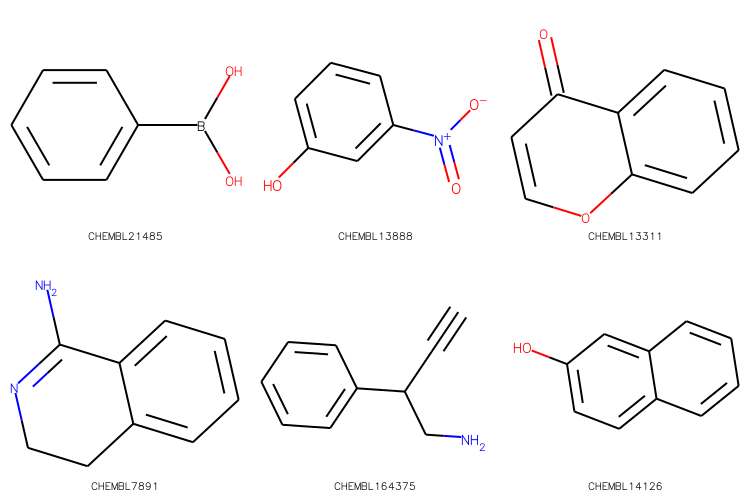

In [25]:
Draw.MolsToGridImage([compound.structure for compound in compounds], legends=[compound.name for compound in compounds], 
                                         subImgSize=(250, 250))

確かにすべてベンゼン環を含む。

RDKit Database Cartridgeでは同時に複数の部分構造を含む部分構造検索したい場合、部分構造をピリオドで繋げば良い。  
以下の例はベンゼン環、インドール環をそれぞれ１つ以上含む部分構造検索はを行う場合のクエリである。

In [26]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.structure.hassubstruct('c1ccccc1.c1ccc2[nH]ccc2c1'))
print(f'{compounds.count()}')

1041


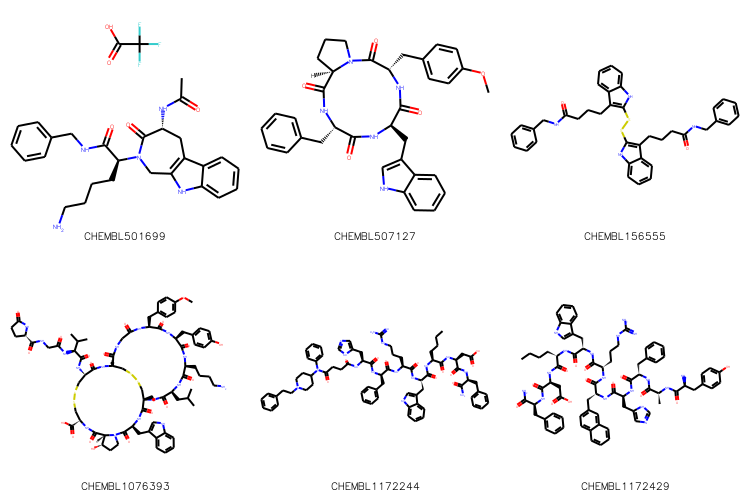

In [27]:
Draw.MolsToGridImage([compound.structure for compound in compounds[:6]], legends=[compound.name for compound in compounds[:6]], 
                                         subImgSize=(250, 250))

確かにすべてベンゼン環、インドール環をそれぞれ１つ以上含む。

#### 4.11 rollbackメソッド

正しくクエリを投げることができなかった場合、続けて別のクエリを投げてもエラーが返ることがある。  
そういう場合は一度`rollback`メソッドでrollbackを行うとよい。

まずわざとエラーを起こしてみる。

In [37]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.id.hassubstruct('c1ccccc1')).limit(5).all()
compounds

AttributeError: Neither 'InstrumentedAttribute' object nor 'Comparator' object associated with Compound.id has an attribute 'hassubstruct'

そうすると改めて正しくコードを書いて実行してもエラーが出ることがある。

In [39]:
compounds = session.query(Compound)
compounds = compounds.filter(Compound.structure.hassubstruct('c1ccccc1')).limit(5).all()
compounds

[(CHEMBL18753) < COc1cc2nc(-c3ccc(F)cc3)nc(O)c2cc1OC >,
 (CHEMBL18720) < CC(=O)c1cc(OCc2cccc(Cl)c2)ccc1OCCCC#N >,
 (CHEMBL18943) < Cc1cc(Br)cc(C(=O)NO)c1N(C)S(=O)(=O)c1ccc(OCC#CCO)cc1 >,
 (CHEMBL18649) < CCCC#CCOc1ccc(S(=O)(=O)N(C)c2c(C)cc(Br)cc2C(=O)NO)cc1 >,
 (CHEMBL19269) < CNCC#CCOc1ccc(S(=O)(=O)N(C)c2c(C)cc(Br)cc2C(=O)NO)cc1 >]

上記のようなエラーが出る場合は一度`session.rollback`メソッドでrollbackを行っておこう。

In [30]:
session.rollback()

In [31]:
compounds = session.query(Compound.name).limit(5).all()
compounds

[('CHEMBL153534'),
 ('CHEMBL440060'),
 ('CHEMBL440245'),
 ('CHEMBL440249'),
 ('CHEMBL405398')]

今後は正しく実行できた。

#### 4.12 closeメソッド

最後はsessionをcloseしておこう。sessionをつながっているとテーブルを削除したりできなくなる。

In [32]:
session.close()

#### 5. テーブルの削除

テーブルの削除は`Base.metadata.remove`メソッドで行える。tutorialで作成したテーブルが必要ないなら実行しよう。

In [ ]:
Base.metadata.remove(Compound)